<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/XGBoost_Machine_Learning_Regression_Training_(T4_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime

from sklearn.model_selection import train_test_split

In [2]:
# Configuration
STATION_ID = "KSLC" # Change as needed
CSV_PATH = "/content/KBOI_2000_2009_f024.csv" # Path to your data (ensure this exists)
TARGET_VARIABLE = "tmax_obs"
PREDICTOR = "tmax_2m" # Minimal: just use tmax_2m as predictor (change as needed)

EXCLUDE_VARS = [] #["tmp_2m", "tmax_2m"]

AFILE_VARS = ["pres_msl", "pres_sfc", "hgt_pres", "tmp_2m", "tmp_pres", "tmin_2m", "tmax_2m", "ugrd_hgt",
              "ugrd_pres", "vgrd_hgt", "vgrd_pres", "dswrf_sfc", "dlwrf_sfc", "uswrf_sfc", "ulwrf_sfc",
              "lhtfl_sfc", "shtfl_sfc", "soil_bgrnd", "tcdc_eatm"]

In [3]:
# Load data
df = pd.read_csv(CSV_PATH)

df['valid_datetime'] = df['valid_datetime'].astype('datetime64[ns]')
df['doy'] = df['valid_datetime'].dt.dayofyear

keep_cols = [c for c in df.columns if (any(var in c for var in AFILE_VARS)
                and not any(var in c for var in EXCLUDE_VARS))]

[keep_cols.append(c) for c in ["valid_datetime", "doy", TARGET_VARIABLE]]

df = df[keep_cols]
df.set_index("valid_datetime", inplace=True)

print(df.columns)

df.dropna(how='any', inplace=True)
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

# First split: train+val and test (e.g., 70% train+val, 30% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: train and val (e.g., from 70% train+val, take 70% train, 30% val ⇒ 49% train, 21% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

df

Index(['pres_msl', 'pres_sfc', 'hgt_pres_925', 'hgt_pres_850', 'hgt_pres_700',
       'tmp_2m', 'tmp_pres_925', 'tmp_pres_850', 'tmp_pres_700', 'tmax_2m',
       'tmin_2m', 'ugrd_hgt', 'ugrd_pres_925', 'ugrd_pres_850',
       'ugrd_pres_700', 'vgrd_hgt', 'vgrd_pres_925', 'vgrd_pres_850',
       'vgrd_pres_700', 'dswrf_sfc', 'dlwrf_sfc', 'uswrf_sfc', 'ulwrf_sfc',
       'lhtfl_sfc', 'shtfl_sfc', 'tcdc_eatm', 'doy', 'tmax_obs'],
      dtype='object')


,pres_msl,pres_sfc,hgt_pres_925,hgt_pres_850,hgt_pres_700,tmp_2m,tmp_pres_925,tmp_pres_850,tmp_pres_700,tmax_2m,...,vgrd_pres_700,dswrf_sfc,dlwrf_sfc,uswrf_sfc,ulwrf_sfc,lhtfl_sfc,shtfl_sfc,tcdc_eatm,doy,tmax_obs
valid_datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02,101353.72750,90042.86042,736.00358,1406.96538,2923.58308,-2.12,-0.84,-2.90,-10.71,-1.38,...,1.22198,180.0,267.33783,68.0,309.75751,20.26607,14.70149,100.0,2,-2.8
2000-01-02,101428.78750,90115.99167,742.41585,1414.23100,2928.55100,-1.99,-0.66,-2.68,-11.62,-0.85,...,-2.89642,150.0,282.00000,57.0,311.41245,17.11140,12.70422,100.0,2,-2.8
2000-01-02,101387.39167,90120.23542,741.93842,1415.94334,2934.75867,-1.13,0.40,-2.16,-10.65,-0.05,...,0.78917,160.0,272.00000,63.0,311.82449,18.96084,4.46164,100.0,2,-2.8
2000-01-02,101390.71250,90102.75625,740.91771,1413.47867,2929.51125,-1.44,-0.11,-2.79,-10.94,-0.42,...,1.41911,175.0,270.00000,68.0,313.00769,19.55219,9.50864,100.0,2,-2.8
2000-01-02,101416.45833,90105.87292,741.47644,1413.22013,2928.80058,-1.95,-0.61,-2.82,-11.25,-0.84,...,-0.39066,170.0,274.00000,63.0,310.67816,19.77952,10.81091,100.0,2,-2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,102733.93750,91330.25000,848.72220,1520.27730,3044.71970,-0.62,0.03,-3.86,-8.38,0.43,...,3.71870,110.0,297.00000,37.0,312.62650,30.17330,-1.45510,100.0,1,3.3
2010-01-01,102908.15620,91474.56250,861.47270,1532.36490,3055.44950,-0.83,-0.26,-3.64,-8.38,0.39,...,2.03420,160.0,285.00000,55.0,314.45300,32.72990,9.42930,100.0,1,3.3
2010-01-01,102844.85160,91408.64840,855.70480,1525.85940,3049.08720,-1.11,-0.51,-4.17,-7.88,0.18,...,3.03200,150.0,289.00000,50.0,313.71710,35.78290,7.40040,97.0,1,3.3


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import KFold, ParameterSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import sys

def run_xgb_cv_progress(X, y, xgb_params, n_splits=5, random_state=42, candidate_num=None, total_candidates=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_true = []
    cv_pred = []
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X)):
        fold_label = f"Candidate {candidate_num}/{total_candidates}, Fold {fold_num+1}/{n_splits}"
        print(f"[CV] {fold_label} training...", flush=True)
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        model = XGBRegressor(**xgb_params)
        model.fit(X_tr, y_tr, verbose=False)
        y_te_pred = model.predict(X_te)
        cv_true.append(y_te)
        cv_pred.append(y_te_pred)
        print(f"[CV] {fold_label} done. R2={r2_score(y_te, y_te_pred):.4f}, RMSE={np.sqrt(mean_squared_error(y_te, y_te_pred)):.4f}", flush=True)
        sys.stdout.flush()
    cv_true = np.concatenate(cv_true)
    cv_pred = np.concatenate(cv_pred)
    return cv_true, cv_pred

def compute_feature_importance(model, X):
    importances = model.feature_importances_
    ser = pd.Series(importances, index=X.columns)
    print("Feature importances (gain):", flush=True)
    print(ser.sort_values(ascending=False), flush=True)
    return ser

def print_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} R2:   {r2:.4f}", flush=True)
    print(f"{name} MAE:  {mae:.4f}", flush=True)
    print(f"{name} RMSE: {rmse:.4f}", flush=True)
    return dict(r2=r2, mae=mae, rmse=rmse)

def diagnostic_plot(X_train, y_train, X_test, y_test,
                   y_test_pred, cv_pred, cv_true,
                   feature_importance, title="XGBoost Diagnostics"):
    feature_names = X_train.columns
    min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
    max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))
    fig = plt.figure(figsize=(18, 10), constrained_layout=True)
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)
    axes = {}
    axes['tl'] = fig.add_subplot(gs[0, 0])
    axes['tm'] = fig.add_subplot(gs[0, 1])
    axes['bl'] = fig.add_subplot(gs[1, 0])
    axes['bm'] = fig.add_subplot(gs[1, 1])
    ax_feat = fig.add_subplot(gs[:, 2])

    # 1. Top left: Test set tmax_2m vs tmax_obs
    axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
    axes['tl'].set_xlabel('tmax_2m (Feature)')
    axes['tl'].set_ylabel('tmax_obs (Target)')
    axes['tl'].set_title('tmax_2m vs Target (Test)')
    axes['tl'].grid(True)
    axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_left = r2_score(y_test, X_test['tmax_2m'])
    mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
    rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
    metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
    axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 2. Top middle: Train set tmax_2m vs tmax_obs
    axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
    axes['tm'].set_xlabel('tmax_2m (Feature)')
    axes['tm'].set_ylabel('tmax_obs (Target)')
    axes['tm'].set_title('tmax_2m vs Target (Train)')
    axes['tm'].grid(True)
    axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_train = r2_score(y_train, X_train['tmax_2m'])
    mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
    rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
    metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
    axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 3. Bottom left: XGB CV Forecast vs tmax_obs (cross-validation)
    axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
    axes['bl'].set_xlabel('XGB CV Forecast')
    axes['bl'].set_ylabel('tmax_obs (Target)')
    axes['bl'].set_title('XGB Cross-Validation Forecast vs Target')
    axes['bl'].grid(True)
    axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    cv_r2 = r2_score(cv_true, cv_pred)
    cv_mae = mean_absolute_error(cv_true, cv_pred)
    cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
    metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
    axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 4. Bottom middle: XGB Forecast vs tmax_obs (Test set)
    axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
    axes['bm'].set_xlabel('XGB Forecast')
    axes['bm'].set_ylabel('tmax_obs (Target)')
    axes['bm'].set_title('XGBoost Forecast vs Target (Test)')
    axes['bm'].grid(True)
    axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
    axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 5. Feature importance (right)
    sorted_idx = np.argsort(feature_importance.values)
    ax_feat.barh(feature_importance.index[sorted_idx], feature_importance.values[sorted_idx], color='darkblue')
    ax_feat.set_xlabel('Gain Importance')
    ax_feat.set_title('XGBoost Feature Importance')
    ax_feat.set_xscale('log')
    ax_feat.grid(axis='x', linestyle='--', alpha=0.7)
    fig.suptitle(title, fontsize=20)
    plt.show()

def drop_low_importance_features(X, feature_importance, percentile=10):
    threshold = np.percentile(feature_importance.values, percentile)
    keep_features = feature_importance[feature_importance > threshold].index.tolist()
    dropped_features = feature_importance[feature_importance <= threshold].index.tolist()
    print(f"Importance drop threshold (10th percentile): {threshold:.5g}", flush=True)
    print(f"Keeping {len(keep_features)} features, Dropping {len(dropped_features)} features ({dropped_features})", flush=True)
    return X[keep_features], keep_features

def xgb_gridsearch_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, debug=False, max_fits=25, n_folds=5):
    assert not X_train.isnull().any().any(), "X_train contains NaN"
    assert not pd.isnull(y_train).any(), "y_train contains NaN"
    assert np.isfinite(X_train.values).all(), "X_train contains inf"
    assert np.isfinite(y_train.values).all(), "y_train contains inf"

    print("\n===== Manual Random Search for XGBoost Hyperparameters (GPU) =====", flush=True)
    param_grid = {
        'max_depth': [3, 5, 7, 10, 12],
        'min_child_weight': [3, 5, 7, 10],
        'gamma': [0, 0.1, 0.3, 0.5],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 2, 5, 10],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    base_params = dict(n_estimators=300, random_state=42, n_jobs=-1, tree_method="hist", device="cuda", eval_metric="rmse")
    param_list = list(ParameterSampler(param_grid, n_iter=max_fits, random_state=42))
    cv_scores = []
    params_used = []
    for cand_idx, params in enumerate(param_list):
        print(f"\n[Candidate {cand_idx+1}/{len(param_list)}] Params: {params}", flush=True)
        all_params = {**base_params, **params}
        cv_true, cv_pred = run_xgb_cv_progress(
            X_train, y_train, all_params, n_splits=n_folds,
            random_state=42, candidate_num=cand_idx+1, total_candidates=len(param_list)
        )
        rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
        print(f"[Candidate {cand_idx+1}/{len(param_list)}] Mean CV RMSE: {rmse:.4f}", flush=True)
        cv_scores.append(rmse)
        params_used.append(all_params)
        if debug and cand_idx == 0:
            print("Debug mode: stopping after first candidate.", flush=True)
            break

    best_idx = int(np.argmin(cv_scores))
    best_params = params_used[best_idx]
    print("\nBest candidate:", best_params, flush=True)
    print(f"Best CV RMSE: {cv_scores[best_idx]:.4f}", flush=True)

    print("\n===== XGBoost Model with Best Hyperparameters (GPU) =====", flush=True)
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train, verbose=False)
    feature_importance = compute_feature_importance(model, X_train)
    print("Running cross-validation on feature-selected features...", flush=True)
    cv_true, cv_pred = run_xgb_cv_progress(
        X_train, y_train, best_params, n_splits=n_folds, random_state=42, candidate_num=1, total_candidates=1
    )
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    val_stats = print_metrics("Validation", y_val, y_val_pred)
    test_stats = print_metrics("Test", y_test, y_test_pred)

    print("\n===== Feature Selection: Drop 10th percentile and below =====", flush=True)
    X_train_fs, keep_features = drop_low_importance_features(X_train, feature_importance, percentile=10)
    X_val_fs = X_val[keep_features]
    X_test_fs = X_test[keep_features]
    model_fs = XGBRegressor(**best_params)
    model_fs.fit(X_train_fs, y_train, verbose=False)
    feature_importance_fs = compute_feature_importance(model_fs, X_train_fs)
    print("Running cross-validation after feature selection (GPU)...", flush=True)
    cv_true_fs, cv_pred_fs = run_xgb_cv_progress(
        X_train_fs, y_train, best_params, n_splits=n_folds, random_state=42, candidate_num=1, total_candidates=1
    )
    y_val_pred_fs = model_fs.predict(X_val_fs)
    y_test_pred_fs = model_fs.predict(X_test_fs)
    val_stats_fs = print_metrics("Validation (FS)", y_val, y_val_pred_fs)
    test_stats_fs = print_metrics("Test (FS)", y_test, y_test_pred_fs)

    # Final diagnostic plot
    diagnostic_plot(
        X_train_fs, y_train,
        X_test_fs, y_test,
        y_test_pred_fs,
        cv_pred_fs, cv_true_fs,
        feature_importance_fs,
        title="XGBoost (Grid Search + Feature Selection, GPU)"
    )

    # Collect and return all relevant stats
    results = {
        "best_model": model_fs,
        "best_params": best_params,
        "cv_rmse": cv_scores[best_idx],
        "feature_importance": feature_importance_fs,
        "validation_stats": val_stats_fs,
        "test_stats": test_stats_fs,
        "selected_features": keep_features,
        "cv_true": cv_true_fs,
        "cv_pred": cv_pred_fs,
        "y_val_pred": y_val_pred_fs,
        "y_test_pred": y_test_pred_fs,
    }
    return results


===== Manual Random Search for XGBoost Hyperparameters (GPU) =====

[Candidate 1/5] Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.9}
[CV] Candidate 1/5, Fold 1/5 training...
[CV] Candidate 1/5, Fold 1/5 done. R2=0.9862, RMSE=1.3476
[CV] Candidate 1/5, Fold 2/5 training...
[CV] Candidate 1/5, Fold 2/5 done. R2=0.9872, RMSE=1.3252
[CV] Candidate 1/5, Fold 3/5 training...
[CV] Candidate 1/5, Fold 3/5 done. R2=0.9848, RMSE=1.4073
[CV] Candidate 1/5, Fold 4/5 training...
[CV] Candidate 1/5, Fold 4/5 done. R2=0.9858, RMSE=1.3885
[CV] Candidate 1/5, Fold 5/5 training...
[CV] Candidate 1/5, Fold 5/5 done. R2=0.9850, RMSE=1.4410
[Candidate 1/5] Mean CV RMSE: 1.3825

[Candidate 2/5] Params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
[CV] Candidate 2/5, Fold 1/5 training...
[CV]

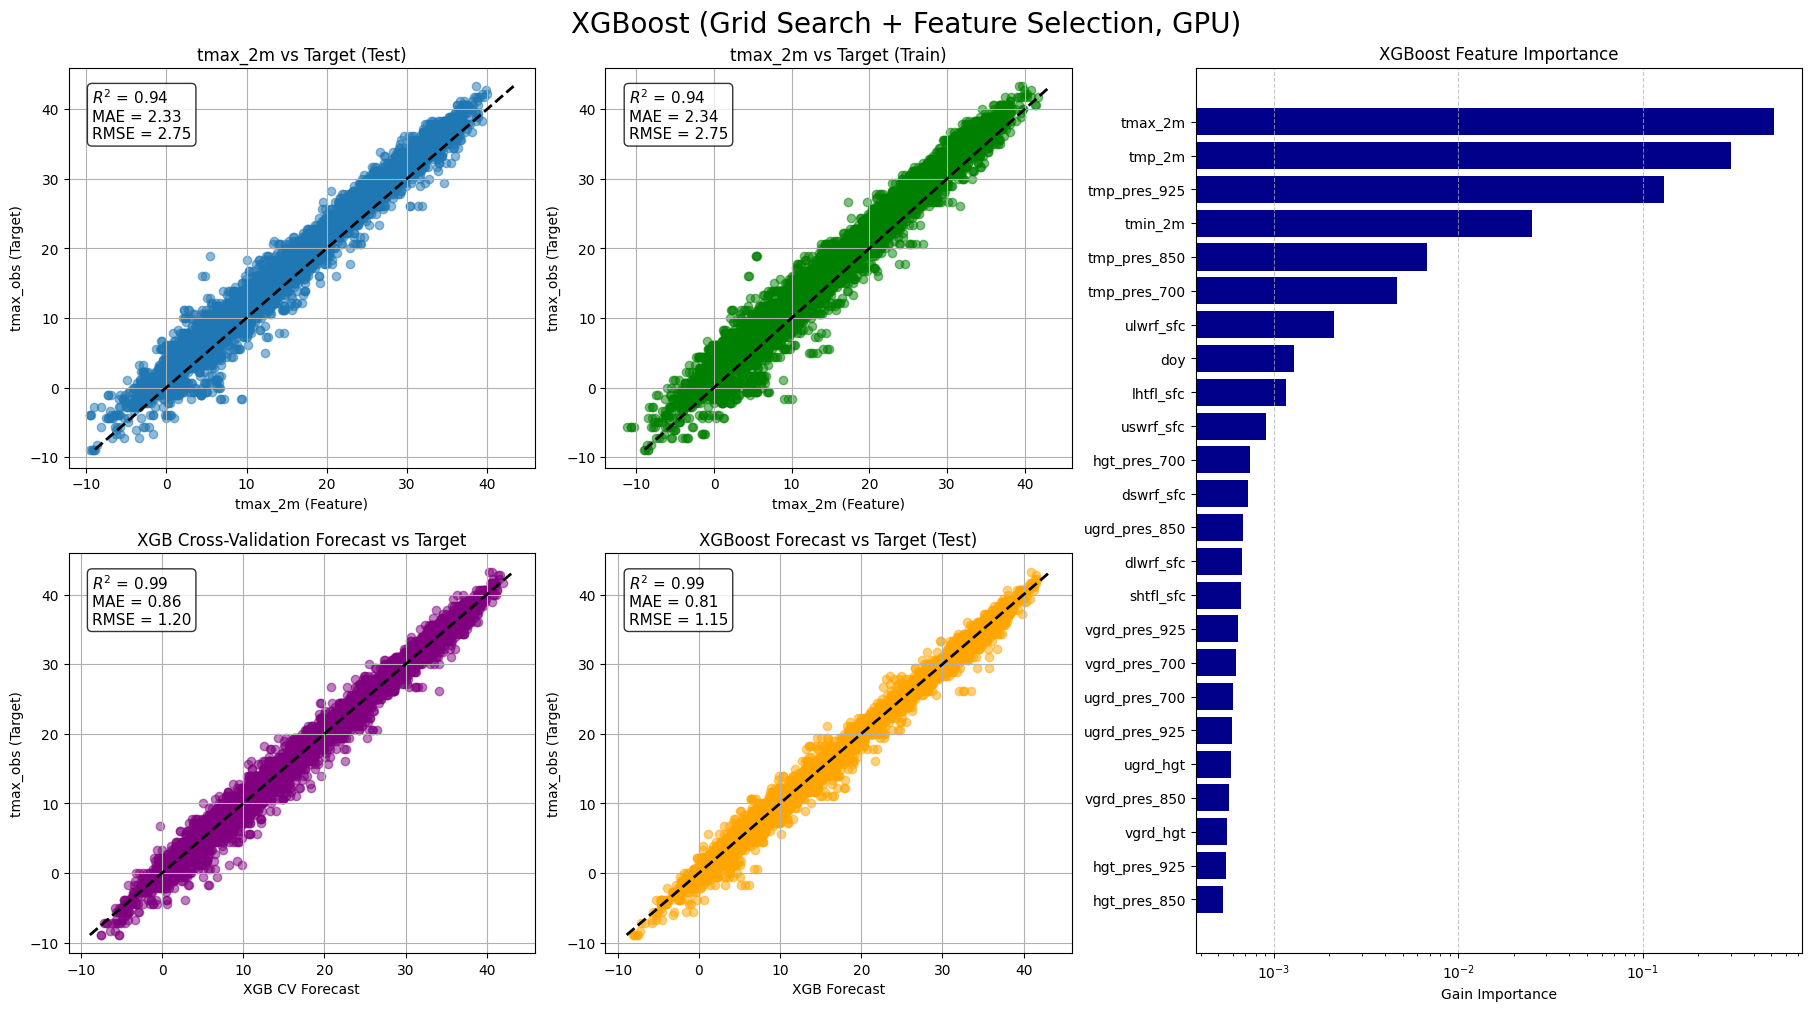

In [81]:
results = xgb_gridsearch_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, max_fits=5, n_folds=5)